<a href="https://colab.research.google.com/github/sanazgit/Water-Potability/blob/main/Water_Potability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pylab import *
import numpy as np
import pandas as pd
from numpy import nan
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler

# Read data

In [ ]:
dataset = read_csv('/content/drive/MyDrive/Colab Notebooks/ANN_Exercises/water_potability.csv')
dataset

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


# Handle Missing Data

In [ ]:
# count the number of missing values for each column
num_missing = dataset.isnull().sum()
num_missing

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

The scikit-learn library provides the **SimpleImputer** pre-processing class that can be used to replace missing values.

It is a flexible class that allows you to specify the value to replace (it can be something other than NaN) and the technique used to replace it (such as mean, median, or mode).

***The SimpleImputer class operates*** directly on the NumPy array instead of the DataFrame.

at the below I use the SimpleImputer class to replace missing values with the mean of each column then prints the number of NaN values in the transformed matrix.

In [ ]:
from sklearn.impute import SimpleImputer # retrieve the numpy array

values = dataset.values
X = values[:,0:9]
y = values[:,9]
# define the imputer
imputer = SimpleImputer(missing_values=nan, strategy='median')
# transform the dataset
data = imputer.fit_transform(X)
# count the number of NaN values in each column
print('Missing: %d' % isnan(data).sum())

Missing: 0


* **Preprocessing data**

In [ ]:
# make train / test dat

from sklearn.model_selection import train_test_split

# define min max scaler
scaler = MinMaxScaler()
X_scaled= scaler.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, shuffle=True)

# **Step 1**

**Nonlinear Neuron**

# ANN Class

In [ ]:
class NeuralNetwork_Momentum():

  def __init__(self, inputs):

    hidden_nodes = 6
    output_labels = 1
    feature_set = inputs.shape[1]
    # each input neuro has 6 weights for each hidden neuron
    self.wh = np.random.rand(feature_set,hidden_nodes)
    self.bh = np.random.randn(hidden_nodes)

    self.wo = np.random.rand(hidden_nodes,output_labels)
    self.bo = np.random.randn(output_labels)

  def sigmoid(self,x):
    return 1 / (1 + np.exp(-x))

  def sigmoid_derivative(self,x):
    return x * (1 - x)

  def relu(self, x):
    out= None
    relu= lambda x: x * (x > 0).astype(float)
    out= relu(x)
    return out

  def relu_deriv(self, input, y):

    dx, x= None, input
    dx= y * (x>=0)

    return dx


  def error(self,predicted, target):
    return np.square(predicted-target)/2

  def error_predicted_deriv(self,predicted, target):
    return (predicted-target)


  def update_w(self,w, delta_w , grad, learning_rate, mue):
    dm= -learning_rate*grad
    dw= mue*delta_w - (1-mue)*dm # Delta_w for the new weight increment
    new_weight= w + dw
    return new_weight, dw

  def think(self, inputs):

    predicted_output = []

    for index in range(len(inputs)):

      data_point= inputs[index]

      u = np.dot(data_point, self.wh) + self.bh
      y = self.relu(u)
      v = np.dot(y, self.wo) + self.bo
      z = self.sigmoid(v)

      if z >= 0.45:
        predicted_class = 1
      else:
        predicted_class= 0

      predicted_output.append(predicted_class)

    return predicted_output

  def train(self, training_set_inputs, y_inputs, test_input, test_out, lr, mue, epochs):

    mse_list = []
    acc_tarin_list, acc_test_list=[], []
    delta_wh, delta_bh=0, 0
    delta_wo, delta_bo=0, 0

    for epoch in range(epochs):

      err_list= []
      dE_wo_list,dE_bo_list= [], []
      dE_dwh_list, dE_dbh_list= [], []

      for index in range(len(training_set_inputs)):

        target = y_inputs[index]
        data_point= training_set_inputs[index]

        # Forward Pass =============
        u = np.dot(data_point, self.wh) + self.bh
        y = self.relu(u)
        v = np.dot(y, self.wo) + self.bo
        z = self.sigmoid(v)

        err_list.append(self.error(z, target))

        # Backward Pass =========
        # Phase 1
        # Calculate the error for every output node independently of each other and update output layer weights.

        # For output1
        dE_dz= self.error_predicted_deriv(target,z) # z is predicted class
        dz_dv= self.sigmoid_derivative(z)
        dv_dwo= y.reshape(1,-1)

        dE_wo= dE_dz * dz_dv* dv_dwo
        dE_bo= dE_dz * dz_dv

        dE_wo_list.append(dE_wo)
        dE_bo_list.append(dE_bo)

        # Phase 2
        # Adjust weights from input layer to hidden layer.
        dv_dy=self.wo
        dE_dy= np.dot(dE_dz * dz_dv , dv_dy.T) # pb1
        dy_du= self.relu_deriv(u,y)

        du_dwh= data_point.reshape(-1,1)
        dp= dE_dy * dy_du
        dp= dp.reshape(-1,1)

        dE_dwh= np.dot(du_dwh, dp.T)
        dE_dbh= dE_dy * dy_du

        dE_dwh_list.append(dE_dwh)
        dE_dbh_list.append(dE_dbh)

      atr, ate= self.Diagnostics(training_set_inputs, y_inputs, test_input, test_out)

      acc_tarin_list.append(atr)
      acc_test_list.append(ate)

      dm_wh= np.array(dE_dwh_list).sum()
      dm_bh= np.array(dE_dbh_list).sum()
      dm_wo= np.array(dE_wo_list).sum()
      dm_bo= np.array(dE_bo_list).sum()

      # ========== Update hidden layer Weights
      self.wh,delta_wh= self.update_w(self.wh, delta_wh, dm_wh, lr, mue)
      self.bh, delta_bh= self.update_w(self.bh, delta_bh, dm_bh, lr, mue)

      # ========== Update output layer Weights
      self.wo, delta_wo= self.update_w(self.wo, delta_wo, dm_wo, lr, mue)
      self.bo, delta_bo= self.update_w(self.bo, delta_bo, dm_bo, lr, mue)

      # ========== Calculate MSE
      err_o= np.array(err_list).sum()
      err_total = err_o / 2 * len(training_set_inputs)
      mse_list.append(err_total)

    return mse_list,acc_tarin_list,acc_test_list


  # The neural network prints its weights
  def print_weights(self):

    print("    Layer 1 (6 neurons, each with 9 inputs): ")
    print('wh: ',self.wh)
    print('bh: ',self.bh)
    print("    Layer 2 (1 neuron, with 6 inputs):")
    print('wo: ',self.wo)
    print('bo: ',self.bo)


  def Diagnostics(self, train_input, train_out, test_input, test_out):

    acc_train= self.Qualitative_analysis(train_input, train_out)
    acc_test= self.Qualitative_analysis(test_input, test_out)

    return acc_train, acc_test



  def Qualitative_analysis(self, xtest, ytest):

    correct_counts=0
    incorrect_counts =0
    actual_class = ytest
    predicted_class = self.think(xtest)

    for index in range(len(xtest)):
      if actual_class[index]  == predicted_class[index]:
        correct_counts += 1
      else:
        incorrect_counts += 1

    accu= ( correct_counts * 1.0) / ((correct_counts + incorrect_counts) * 1.0)
    print("ACCURACY:")
    print("Model Accuracy:", accu)

    return accu

* **Train the ANN model**

In [ ]:
lr= 4e-3
an= NeuralNetwork_Momentum(X_train)
ytrain=y_train.reshape(-1,1)
ytest=y_test.reshape(-1,1)
MSE, ac_train, ac_test= an.train( X_train,ytrain,X_test,ytest,lr,0.01, 200)

ACCURACY:
Model Accuracy: 0.3885739206279983
ACCURACY:
Model Accuracy: 0.3936927772126144
ACCURACY:
Model Accuracy: 0.3885739206279983
ACCURACY:
Model Accuracy: 0.3936927772126144
ACCURACY:
Model Accuracy: 0.3885739206279983
ACCURACY:
Model Accuracy: 0.3936927772126144
ACCURACY:
Model Accuracy: 0.6114260793720018
ACCURACY:
Model Accuracy: 0.6063072227873856
ACCURACY:
Model Accuracy: 0.6114260793720018
ACCURACY:
Model Accuracy: 0.6063072227873856
ACCURACY:
Model Accuracy: 0.6114260793720018
ACCURACY:
Model Accuracy: 0.6063072227873856
ACCURACY:
Model Accuracy: 0.6114260793720018
ACCURACY:
Model Accuracy: 0.6063072227873856
ACCURACY:
Model Accuracy: 0.6114260793720018
ACCURACY:
Model Accuracy: 0.6063072227873856
ACCURACY:
Model Accuracy: 0.6114260793720018
ACCURACY:
Model Accuracy: 0.6063072227873856
ACCURACY:
Model Accuracy: 0.6114260793720018
ACCURACY:
Model Accuracy: 0.6063072227873856
ACCURACY:
Model Accuracy: 0.6114260793720018
ACCURACY:
Model Accuracy: 0.6063072227873856
ACCURACY:


* **MSE Plot**

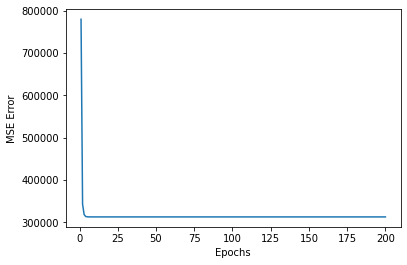

In [ ]:
plt.plot(range(1, len(MSE) + 1), MSE)
plt.xlabel('Epochs')
plt.ylabel('MSE Error')
plt.show()

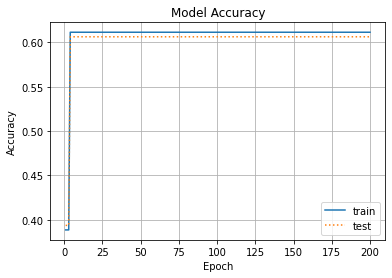

In [ ]:
plt.plot(range(1, len(ac_train) + 1), ac_train)
plt.plot(range(1, len(ac_test) + 1), ac_test,ls =':')


plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"], loc ="lower right")
plt.grid()

plt.show()

* **Final Weights**

In [ ]:
an.print_weights()

    Layer 1 (6 neurons, each with 9 inputs): 
wh:  [[-0.71322259 -0.84031545 -1.18861412 -0.65042529 -1.16254841 -0.89951782]
 [-0.99546618 -1.03158439 -1.19972947 -0.89512829 -1.0183218  -1.18414493]
 [-1.18011207 -1.07891967 -1.10482654 -0.98750884 -0.59065885 -0.69798768]
 [-1.03817964 -0.87057542 -1.03448666 -1.06760734 -0.74929314 -1.1108534 ]
 [-0.96124078 -0.2845443  -1.27787259 -0.47528815 -0.60906848 -1.15457359]
 [-0.46336082 -0.4479959  -0.41664908 -0.65728187 -0.98879348 -1.12799628]
 [-0.48200477 -0.86368965 -0.7746081  -1.25280013 -0.9352752  -0.94649299]
 [-0.95828951 -0.86543097 -0.73034548 -0.50596299 -0.69218513 -0.31371609]
 [-0.35046268 -0.68947541 -0.62351306 -0.3648785  -0.76528856 -1.05187543]]
bh:  [-2.06170595 -1.476884   -0.07179597 -1.5370718  -1.81819123 -0.25270683]
    Layer 2 (1 neuron, with 6 inputs):
wo:  [[ 0.24088442]
 [ 0.20411158]
 [ 0.20913133]
 [ 0.35605072]
 [-0.08112124]
 [ 0.21785997]]
bo:  [-0.45331064]


* **Accuracy**

In [ ]:
ytest=y_test.reshape(-1,1)
ac=an.Qualitative_analysis(X_test,ytest)

ACCURACY:
Model Accuracy: 0.6063072227873856


# **Step 2**

**Linear Neuron**

# ANN Class

In [ ]:
class LinearNeuron(object):

  def __init__(self, lr, epochs):

    self.lr = lr
    self.epochs= epochs

  def net_input(self,X):

    """Calculate net input"""

    return np.dot(X, self.weights[1:]) + self.weights[0]

  def activation(self, X):

    """Compute linear activation"""

    return self.net_input(X)

  def predict(self, X):

    """Return class label after unit step"""

    return np.where(self.activation(X) >= 0.45, 1, 0)


  def fit_model(self, X,y):

    """Updating weights and calculating MSE"""

    self.mse_list=[]
    self.errors=[]

    self.weights = np.zeros(1 + X.shape[1])

    for epoch in range(self.epochs):

      output = self.net_input(X)

      errors = y - output
      #update weights
      self.weights[1:] += self.lr * (X.T.dot(errors) / len(X))
      self.weights[0] += self.lr * (errors.sum() / len(X))
      #MSE
      cost_mse = (np.square(errors)).sum() / 2.0 * len(X)
      self.mse_list.append(cost_mse)

    return self



  def calculate_accuracy(self, testX,testY):

    """
    Calculates the accuracy of the classifier by running algorithm against test set and comparing
    the output to the actual categorization.
    """
    correct, incorrect = 0, 0

    actual_class = testY
    predicted_class = self.predict(testX)

    for index in range(len(actual_class)):

      if actual_class[index] == predicted_class[index]:
        correct += 1
      else:
        incorrect += 1

    print("ACCURACY:")
    print("Model Accuracy:", (correct * 1.0) / ((correct + incorrect) * 1.0))


In [ ]:
aln1 = LinearNeuron(0.6,100)
aln1.fit_model(X_train,y_train)

* **Final weights**


In [ ]:
aln1.weights

array([ 0.17799979,  0.06696842,  0.00223532,  0.10318451,  0.15643692,
       -0.01421914,  0.00591055, -0.00178196,  0.0637736 ,  0.05790356])

* **MSE Plot**

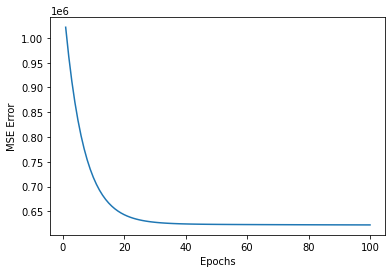

In [ ]:
mse_train= aln1.mse_list

plt.plot(range(1, len(mse_train) + 1), mse_train)
plt.xlabel('Epochs')
plt.ylabel('MSE Error')
plt.show()

* **Accuracy**

In [ ]:
aln2.calculate_accuracy(X_test,y_test)

ACCURACY:
Model Accuracy: 0.6276703967446592
